In [1]:
%load_ext autoreload
%autoreload 2



import librosa
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np
from tqdm import tqdm
from preprocess import *
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

Using TensorFlow backend.


### for the next part to run the data needs to be extracted and placed in the folders as SPEECH_DATAA_PATH and URBAN_NOISE_DATA_PATH locations.

In [2]:
SPEECH_DATA_PATH = "./speech/data/"

URBAN_NOISE_DATA_PATH = "./urban/data/"

COMBINED_DATA_PATH = "./combined/data/"

SPEECH_NPY_PATH = "./40bins/npy/"

URBAN_NOISE_NPY_PATH = "./40bins/npy/"

COMBINED_NPY_PATH =  "./combined/40bins/npy/"

COMBINED_MODEL_SAVE_PATH = "./models/40bins"

In [3]:
# speech test and val file paths
testFile = "./data/testing_list.txt"
valFile = "./data/validation_list.txt"


### function to convert wav file to mfccs

In [4]:
##function to convert wav2mfcc
# samp rate of the speech wav files is 16000
# samp rate of the urban noise wav files is 8000
# use the samprate argument to change that.... will downsample speech wav files to 8000 in the future to make it easier
def wav2mfcc(file_path, max_len=11,samprate = 8000):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    wave = wave[::3]
    ##mfcc = librosa.feature.mfcc(wave, sr=16000)
    mfcc = librosa.feature.mfcc(wave, sr=samprate)
    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Else cutoff the remaining parts
    else:
        mfcc = mfcc[:, :max_len]
    
    return mfcc

In [5]:
# args: Folder Path
# Output: Tuple (Label, Indices of the labels, one-hot encoded labels)
# make sure the background noise folder is not insde the DATA_PATH. because that is used for data augmentation and not recognition
def get_labels(path=COMBINED_DATA_PATH):
    labels = os.listdir(path)
    label_indices = np.arange(0, len(labels))
    return labels, label_indices, to_categorical(label_indices)


### function to extract and save speech data features

In [6]:
# write the save data code here....with test train and val split
# make sure the background_noise folder is not in the path
def save_data_speech(path = SPEECH_DATA_PATH, testFile = testFile, valFile = valFile, max_len = 11,savepath = SPEECH_NPY_PATH):

    test_file = open(testFile, "r")
    testFilesList = test_file.read().split('\n')

    val_file = open(valFile, "r")
    valFilesList = val_file.read().split('\n')

    #print(testFilesList)
    #print(valFilesList)
    labels,_,_ = get_labels(path)
    print(labels)
    for label in labels:
        mfcc_train = []
        mfcc_test = []
        mfcc_val = []
        # saving a tuple of wavfile path and label/name format to compare in the test and val list
        wavfiles = [(path + label + '/' + wavfile, label + '/' + wavfile)
                    for wavfile in os.listdir(path + '/' + label)]
        
        #print(wavfiles)
        
        for wavfile in tqdm(wavfiles, "Saving vectors of label - '{}'".format(label)):
            #print(wavfile[0])
            #print(wavfile[1])
            mfcc = wav2mfcc(wavfile[0], max_len=max_len)
            if wavfile[1] in testFilesList:
                mfcc_test.append(mfcc)
            elif wavfile[1] in valFilesList:
                mfcc_val.append(mfcc)
            else:
                mfcc_train.append(mfcc)
                
        np.save(savepath + label + '_test.npy', mfcc_test)
        np.save(savepath + label + '_val.npy', mfcc_val)
        np.save(savepath + label + '_train.npy', mfcc_train)

### function to extract and save urban sounds features

In [7]:
# just saving the urban data as the npy file.
# will split the data into test train and val after loading the data nd the labels by using a test_train split function
def save_urbanNoise_data(path = URBAN_NOISE_DATA_PATH, max_len = 11, savePath = URBAN_NOISE_NPY_PATH):
    labels,_,_ = get_labels(path)
    for label in labels:
        mfccs = []
        mfcc_train = []
        mfcc_test = []
        mfcc_val = []
        print(label)
        
        wavfiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        
        for wavfile in tqdm(wavfiles, "saving vectors of label - '{}'".format(label)):
            try:
                mfcc = wav2mfcc(wavfile, max_len = max_len)
                mfccs.append(mfcc)
            except:
                print(wavfile)
        
        np.save(savePath + label + '.npy', mfccs)

In [8]:
# save data
# Second dimension of the feature is dim2
feature_dim_2 = 40      #max_len

In [10]:


# speech data
save_data_speech(max_len = feature_dim_2)


['down', 'learn', 'right', 'nine', 'eight', 'dog', 'bird', 'house', 'marvin', 'zero', 'sheila', 'bed', 'follow', 'off', 'happy', 'backward', 'on', 'cat', 'left', 'five', 'visual', 'one', 'no', 'two', 'yes', 'forward', 'tree', 'three', 'go', 'seven', 'six', 'wow', 'stop', 'four', 'up']


Saving vectors of label - 'up': 100%|██████████| 3723/3723 [01:00<00:00, 61.22it/s]


In [11]:
#urban Noise data
save_urbanNoise_data(max_len = feature_dim_2)

air_conditioner


saving vectors of label - 'dog_bark':   0%|          | 0/1000 [00:00<?, ?it/s]

dog_bark


saving vectors of label - 'dog_bark': 100%|██████████| 1000/1000 [00:57<00:00, 15.77it/s]


street_music


saving vectors of label - 'car_horn':   0%|          | 0/429 [00:00<?, ?it/s]

car_horn


saving vectors of label - 'drilling':   0%|          | 0/1000 [00:00<?, ?it/s]

drilling


saving vectors of label - 'drilling': 100%|██████████| 1000/1000 [01:05<00:00, 15.35it/s]


children_playing


saving vectors of label - 'siren':   0%|          | 0/928 [00:00<?, ?it/s]

siren


saving vectors of label - 'engine_idling':   0%|          | 0/1000 [00:00<?, ?it/s]

engine_idling


saving vectors of label - 'engine_idling': 100%|██████████| 1000/1000 [01:09<00:00, 14.33it/s]


jackhammer


saving vectors of label - 'jackhammer':  39%|███▉      | 389/1000 [00:27<00:35, 17.01it/s]

/media/tintin/3bde46c1-cca7-4db6-b2ca-e71397572866/tintin/speech-urban-data/urban/data/jackhammer/188823-7-1-1.wav


saving vectors of label - 'gun_shot':   0%|          | 0/374 [00:00<?, ?it/s]

gun_shot


saving vectors of label - 'gun_shot': 100%|██████████| 374/374 [00:18<00:00, 20.66it/s]


### function to import urban noise features data

In [9]:
# get the urbanNoiseData along with their labels then split them into train,val and split and save as npy files
# we will get all the data from all the classes append them into an array and then use a test train split function
def getUrbanNoiseDataSplit(path = URBAN_NOISE_DATA_PATH, savePath = URBAN_NOISE_NPY_PATH, split_ratio=0.8,random_state = 42):
    labels, indices, _ = get_labels(path)
    # get the array for each label
    X = np.load(savePath + labels[0] + '.npy')
    Y = np.zeros(X.shape[0])

    # Append all of the dataset into one single array, same goes for y
    # filling with i+1 in each loop so basically starting the class values from 0 to 9.
    for i, label in enumerate(labels[1:]):
        x = np.load(savePath + label + '.npy')
        X = np.vstack((X, x))
        Y = np.append(Y, np.full(x.shape[0], fill_value= (i + 1)))

    assert X.shape[0] == len(Y)
    
    # not shuffling the data for now. Will shuffle them while training
    X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)
    X_train, X_val, Y_train, Y_val = train_test_split(X_temp,Y_temp, test_size = (1-split_ratio), random_state = random_state,shuffle = True)
    
    return labels,X_train,X_val,X_test,Y_train,Y_val,Y_test

### function to import speech commands features data

In [10]:
# for speech we already split the data into train test and val and then saved the data. 
# so now we just need to import the data and then append all the labels
def getSpeechDataSplit(path = SPEECH_DATA_PATH, savePath = SPEECH_NPY_PATH):
    
    labels, indices, _ = get_labels(path)
    # get the array for each label
    X_train = np.load(savePath + labels[0] + '_train.npy')
    Y_train = np.zeros(X_train.shape[0])
    X_val = np.load(savePath + labels[0] + '_val.npy')
    Y_val = np.zeros(X_val.shape[0])
    X_test = np.load(savePath + labels[0] + '_test.npy')
    Y_test = np.zeros(X_test.shape[0])
    
    for i,label in enumerate(labels[1:]):
        x_train = np.load(savePath + label + '_train.npy')
        x_val = np.load(savePath + label + '_val.npy')
        x_test = np.load(savePath + label + '_test.npy')
        X_train = np.vstack((X_train, x_train))
        X_val = np.vstack((X_val, x_val))
        X_test = np.vstack((X_test, x_test))
        
        Y_train = np.append(Y_train, np.full(x_train.shape[0],fill_value= (i+1)))
        Y_val = np.append(Y_val, np.full(x_val.shape[0],fill_value= (i+1)))
        Y_test = np.append(Y_test, np.full(x_test.shape[0],fill_value= (i+1)))
    
        
    return labels,X_train,X_val,X_test,Y_train,Y_val,Y_test

In [11]:
# # Loading train set and test set of urban Noise
labels_un, X_train_un,X_val_un, X_test_un, Y_train_un,Y_val_un, Y_test_un = getUrbanNoiseDataSplit()
print(labels_un)

['air_conditioner', 'dog_bark', 'street_music', 'car_horn', 'drilling', 'children_playing', 'siren', 'engine_idling', 'jackhammer', 'gun_shot']


In [12]:
# # Loading train set and test set of speech
labels_sp, X_train_sp,X_val_sp, X_test_sp, Y_train_sp,Y_val_sp, Y_test_sp = getSpeechDataSplit()
print(labels_sp)

['down', 'learn', 'right', 'nine', 'eight', 'dog', 'bird', 'house', 'marvin', 'zero', 'sheila', 'bed', 'follow', 'off', 'happy', 'backward', 'on', 'cat', 'left', 'five', 'visual', 'one', 'no', 'two', 'yes', 'forward', 'tree', 'three', 'go', 'seven', 'six', 'wow', 'stop', 'four', 'up']


In [13]:
# print shapes of all arrays
X_train_un.shape,X_val_un.shape, X_test_un.shape, Y_train_un.shape,Y_val_un.shape, Y_test_un.shape

((5587, 20, 40), (1397, 20, 40), (1746, 20, 40), (5587,), (1397,), (1746,))

In [14]:
X_train_sp.shape,X_val_sp.shape, X_test_sp.shape, Y_train_sp.shape,Y_val_sp.shape, Y_test_sp.shape

((84843, 20, 40), (9981, 20, 40), (11005, 20, 40), (84843,), (9981,), (11005,))

In [15]:
# if we want to combine both the samples we just need to add the Y sample with the numeber of labels in the previous dataset

# combining samples
labels = labels_sp + labels_un
print(len(labels))



45


### merging the data

In [16]:
# we add 35 to the urban Noise Y data to make them into the new labels


Y_train_un_new = Y_train_un + 35
Y_test_un_new = Y_test_un + 35
Y_val_un_new = Y_val_un + 35



In [17]:
Y_train = np.append(Y_train_sp, Y_train_un_new)
Y_test = np.append(Y_test_sp, Y_test_un_new)
Y_val = np.append(Y_val_sp, Y_val_un_new)

print(Y_train.shape)
print(Y_test.shape)
print(Y_val.shape)

(90430,)
(12751,)
(11378,)


In [18]:
print(Y_test)
print(Y_train)
print(Y_val)

[ 0.  0.  0. ... 39. 37. 35.]
[ 0.  0.  0. ... 37. 38. 42.]
[ 0.  0.  0. ... 39. 36. 41.]


In [19]:
X_train = np.vstack((X_train_sp, X_train_un))
X_test = np.vstack((X_test_sp, X_test_un))
X_val = np.vstack((X_val_sp, X_val_un))


print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(90430, 20, 40)
(12751, 20, 40)
(11378, 20, 40)


In [20]:
# we have combined data set and seperate datasets
# X_train_un, X_test_un, X_val_un, Y_train_un, Y_test_un, Y_val_un ---urban Noise data - 10 clasees - (0-9)
# X_train_sp, X_test_sp, X_val_sp, Y_train_sp, Y_test_sp, Y_val_sp --- speech data - 35 classes - (0-34)
# X_train, X_test, X_val, Y_train, Y_test, Y_val --- combined dtat - 45 classes (0-44)

In [21]:
# # Feature dimension
feature_dim_1 = 20
channel = 1
epochs = 200
batch_size = 100
verbose = 1
num_classes = 45    #keeps changing


In [22]:
# Reshaping to perform 2D convolution
# all data

X_train = X_train.reshape(X_train.shape[0], feature_dim_1, feature_dim_2, channel)
X_val = X_val.reshape(X_val.shape[0], feature_dim_1, feature_dim_2, channel)
X_test = X_test.reshape(X_test.shape[0], feature_dim_1, feature_dim_2, channel)

Y_train_hot = to_categorical(Y_train)
Y_val_hot = to_categorical(Y_val)
Y_test_hot = to_categorical(Y_test)

In [23]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

print(Y_train_hot.shape)
print(Y_test_hot.shape)
print(Y_val_hot.shape)

(90430, 20, 40, 1)
(12751, 20, 40, 1)
(11378, 20, 40, 1)
(90430, 45)
(12751, 45)
(11378, 45)


### Model definition

In [24]:
def get_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
    model.add(Conv2D(120, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(120, kernel_size=(2, 2), activation='relu'))
    model.add(Conv2D(120, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

### Training

In [26]:


model = get_model()

# checkpoint
filepath= "./models/model2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(X_train, Y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, 
                    validation_data=(X_test, Y_test_hot), callbacks=callbacks_list, )

NameError: name 'Y_train_hot' is not defined

In [25]:
# loading the model with the best val accuracy
model = get_model()
weights_path = COMBINED_MODEL_SAVE_PATH + "all_data-93-0.83.hdf5"
model.load_weights(weights_path)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 19, 39, 32)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 38, 48)        6192      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 37, 120)       23160     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 18, 120)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 18, 120)        0         
_________________________________________________________________
conv2d_4 (Conv2D)    

### training plots

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


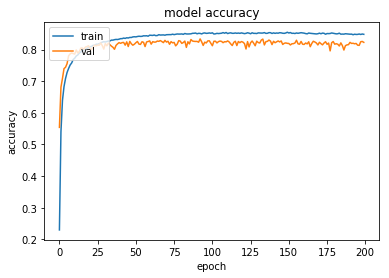

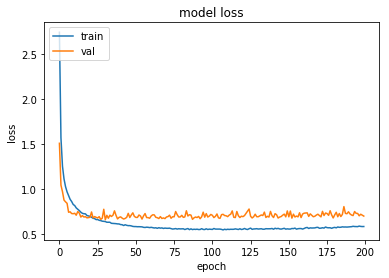

In [31]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(COMBINED_MODEL_SAVE_PATH + 'model_accuracy.png')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(COMBINED_MODEL_SAVE_PATH + 'model_loss.png')
plt.show()


In [32]:
#train and test loss and scores respectively
train_loss_score=model.evaluate(X_train,Y_train_hot)
val_loss_score=model.evaluate(X_val,Y_val_hot)
test_loss_score=model.evaluate(X_test,Y_test_hot)
print(train_loss_score)
print(val_loss_score)
print(test_loss_score)

12751/12751 [==============================] - 2s 119us/step
[0.24104025843664986, 0.9328209664934203]
[0.6014901317680923, 0.8492705220182073]
[0.6722559504448764, 0.8334248294391666]


In [33]:
# Predicts one sample
labels = ['down', 'learn', 'right', 'nine', 'eight', 'dog', 'bird', 'house',
 'marvin', 'zero', 'sheila', 'bed', 'follow', 'off', 'happy', 'backward', 'on',
  'cat', 'left', 'five', 'visual', 'one', 'no', 'two', 'yes', 'forward', 'tree',
   'three', 'go', 'seven', 'six', 'wow', 'stop', 'four', 'up','air_conditioner',
   'dog_bark', 'street_music', 'car_horn', 'drilling', 'children_playing',
    'siren', 'engine_idling', 'jackhammer', 'gun_shot']

def predict(filepath, model,labels):
    mfcc = wav2mfcc(testFile, max_len=40)
    mfcc_reshaped = mfcc.reshape(1,feature_dim_1,feature_dim_2,channel)
    odds= model.predict(mfcc_reshaped)
    odds_max = np.argmax(odds)
    label = labels[odds_max]
    return label

In [34]:
testFile = SPEECH_DATA_PATH + 'happy/27c30960_nohash_0.wav'
print(predict(testFile,model,labels))

happy


In [32]:
from keras.utils import plot_model
feature_dim_1 = 20
channel = 1

num_classes = 45 
#max_len
model = get_model()
plot_model(model, show_shapes = True, show_layer_names = True,to_file='model.png')